In [1]:
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv("GenreDataModified.csv")
df = pd.DataFrame(data)
df = df.dropna()

X = df.drop(['Id','title','artist','year','top genre', 'adjusted top genre'], axis = 1)
y = df['adjusted top genre']

#Normalize each fields of input
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X_rescaled = pd.DataFrame(data = X_rescaled, columns = X.columns)
#X_rescaled = X_rescaled.fillna(0)
print(X_rescaled)

#one-hot encoding
set_of_classes = y.value_counts().index.tolist()
set_of_classes= pd.DataFrame({'adjusted top genre': set_of_classes})
y_onehot = pd.get_dummies(y)
print(y_onehot)

# Combine the normalized input features and the target variable
data0 = pd.concat([X, y], axis=1)			#data without onehot-encoding class
data1 = pd.concat([X_rescaled, y_onehot], axis=1)	#data with onehot-encoding class


          bpm      nrgy      dnce        dB      live       val       dur  \
0    0.328467  0.258065  0.346154  0.695652  0.120879  0.236559  0.125908   
1    0.313869  0.311828  0.576923  0.652174  0.120879  0.655914  0.355932   
2    0.788321  0.225806  0.371795  0.347826  0.120879  0.290323  0.324455   
3    0.430657  0.430108  0.487179  0.695652  0.142857  0.365591  0.230024   
4    0.350365  0.526882  0.679487  0.739130  0.109890  0.182796  0.302663   
..        ...       ...       ...       ...       ...       ...       ...   
433  0.131387  0.161290  0.000000  0.304348  0.087912  0.107527  0.280872   
434  0.627737  0.795699  0.448718  0.478261  0.230769  0.967742  0.118644   
435  0.773723  0.516129  0.705128  0.695652  0.197802  0.591398  0.462470   
436  0.751825  0.860215  0.589744  0.826087  0.043956  0.881720  0.225182   
437  0.313869  0.709677  0.641026  0.695652  0.131868  0.946237  0.443099   

        acous      spch       pop  
0    0.757576  0.022222  0.310345  
1  

In [2]:
"""
# Create a pair plot
sns.set(style="whitegrid")
g = sns.pairplot(data=data0, hue="Class", corner=True, palette='husl')

plt.show()
"""

'\n# Create a pair plot\nsns.set(style="whitegrid")\ng = sns.pairplot(data=data0, hue="Class", corner=True, palette=\'husl\')\n\nplt.show()\n'

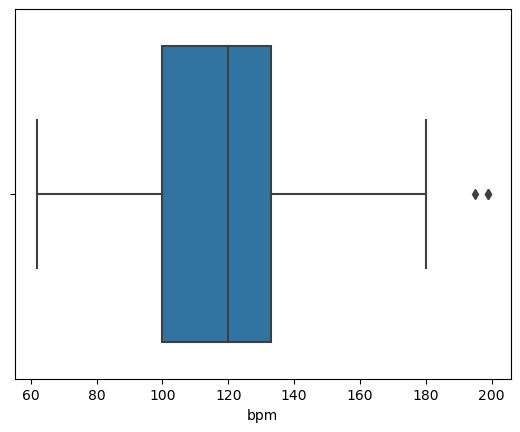

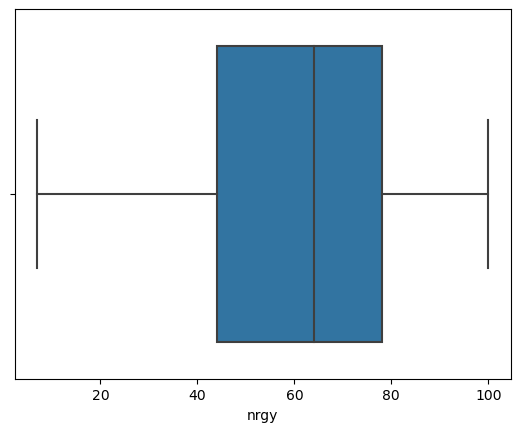

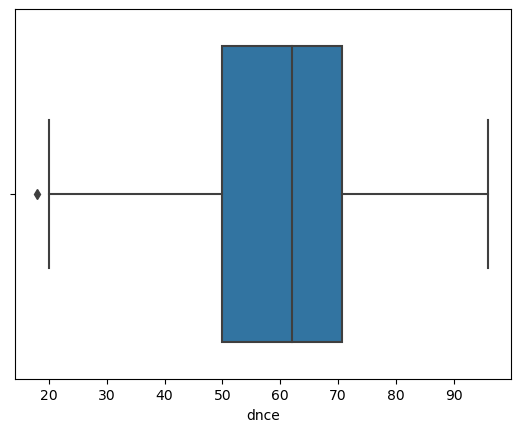

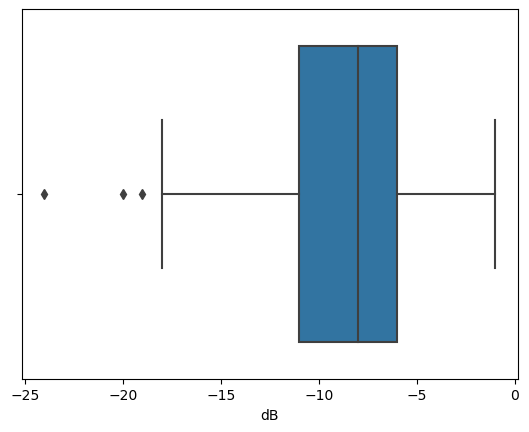

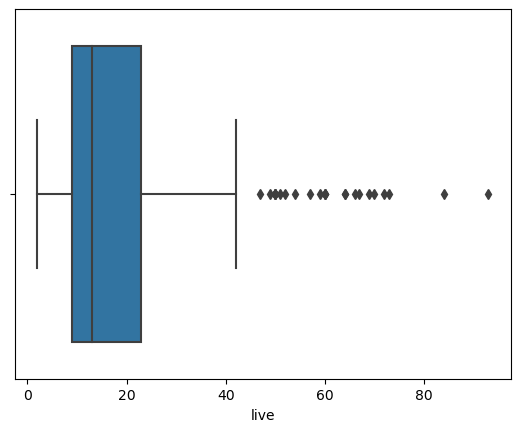

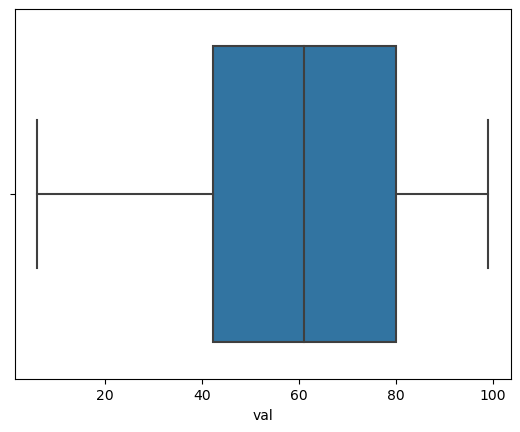

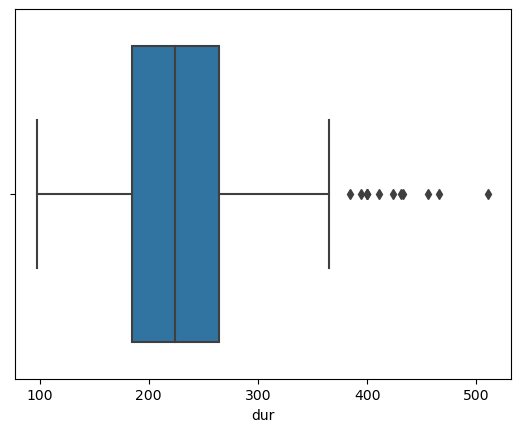

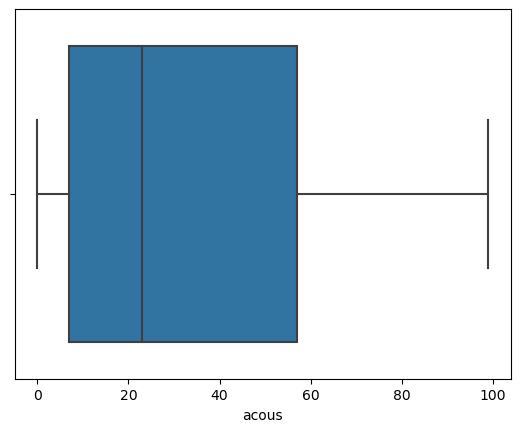

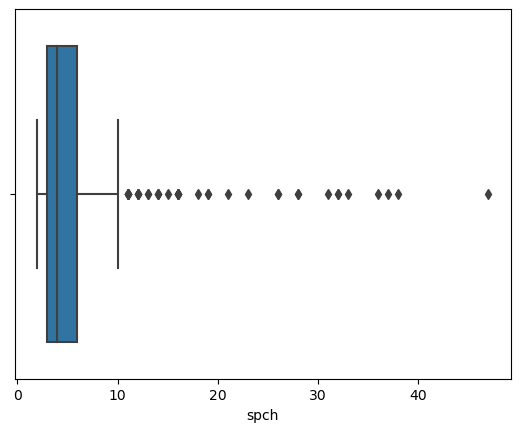

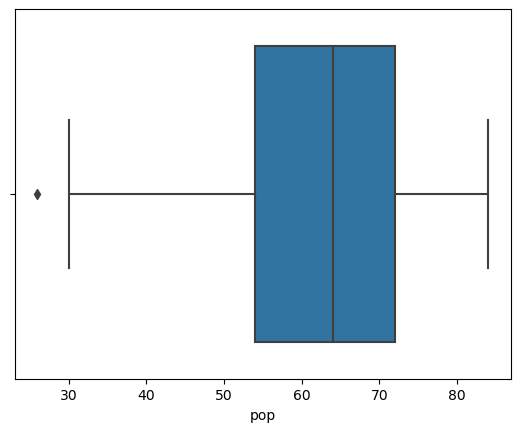

In [3]:
#Investigating possible outliers for various attributes
import seaborn as sns
sns.boxplot(x=df['bpm']) #outliers to right (not a lot)
plt.show()
sns.boxplot(x=df['nrgy']) #no outliers
plt.show()
sns.boxplot(x=df['dnce']) #outlier to left
plt.show()
sns.boxplot(x=df['dB']) # outliers to left (less)
plt.show()
sns.boxplot(x=df['live']) # many outliers (right)
plt.show()
sns.boxplot(x=df['val']) # no outliers
plt.show()
sns.boxplot(x=df['dur']) # many outliers (right)
plt.show()
sns.boxplot(x=df['acous']) # no visible outliers
plt.show()
sns.boxplot(x=df['spch']) # many outliers (right)
plt.show()
sns.boxplot(x=df['pop']) # less outliers (left)
plt.show()

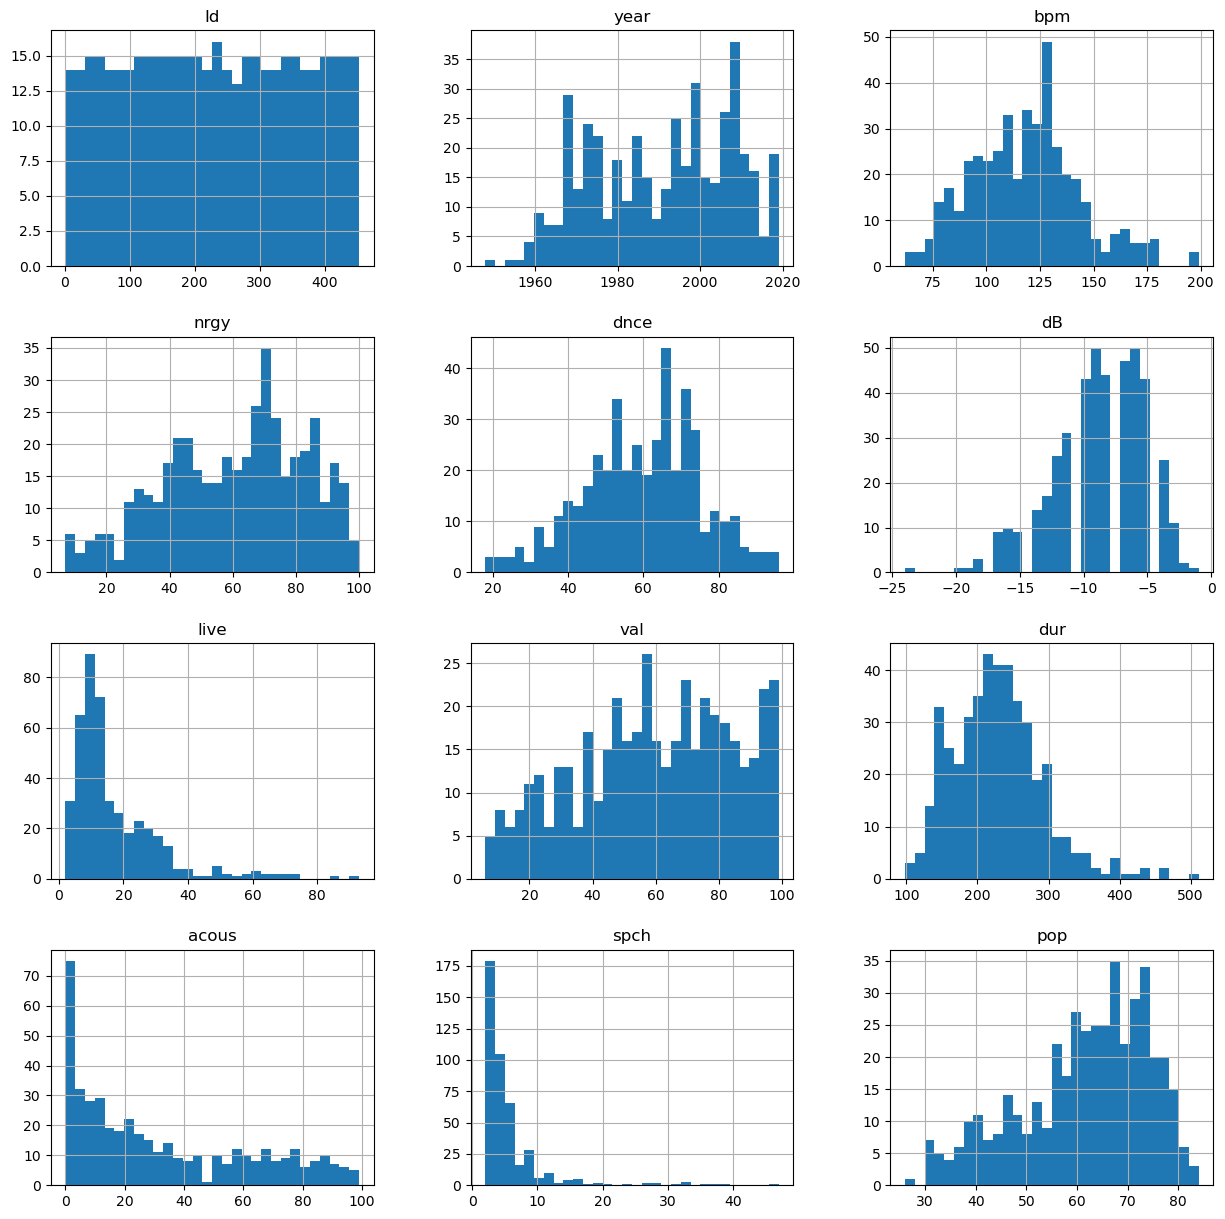

In [4]:
#Investigating skew of data
df.hist(bins=30, figsize=(15,15))
plt.show()

#right skewed for 'live', 'acous', 'spch', 'dur' attributes
#left skewed for 'nrgy', 'dB', 'val', 'pop' attributes
#roughly symmetrical for 'dnce', 'bpm' attributes
#ID and year distributions aren't being analyzed here -- categorical variables that don't affect response variable clas

# Conclusions Based on Histograms and Boxplots

Distributions of attributes dnce, bpm, nrgy, and val are roughly (ROUGHLY) symmetrical so should contribute to more accurate response variable classifications whereas the skewed nature (indicating many outliers) of other attributes could contribute to more inaccurate predictions (higher variance).

In [5]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


models = [
    ("dtree", DecisionTreeClassifier()),
    ("svm", OneVsRestClassifier(SVC(kernel='linear', C=1))),
    ("svm_p", OneVsRestClassifier(SVC(kernel='poly', C=1))),
    ("mlp",  MLPClassifier()),
         ]

In [6]:
import warnings
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

df_metrics = pd.DataFrame(index=["name", "accuracy", "precision", "f1_score"])
n=0
for name, model in models:
    x_train, x_test, y_train, y_test = train_test_split(X_rescaled, y_onehot, test_size=0.1, random_state=42)
    
    # Ensure y_train and y_test are single-column arrays (not one-hot encoded)
    y_train_single = y_train.idxmax(axis=1)
    y_test_single = y_test.idxmax(axis=1)

    model.fit(x_train, y_train_single)
    y_pred = model.predict(x_test)

    metrics = [name]
    metrics.append(accuracy_score(y_test_single, y_pred))
    metrics.append(precision_score(y_test_single, y_pred, average="weighted"))
    metrics.append(f1_score(y_test_single, y_pred, average="weighted"))

    df_metrics[n] = metrics
    n += 1
    
display(df_metrics)

,0,1,2,3
name,dtree,svm,svm_p,mlp
accuracy,0.363636,0.318182,0.477273,0.5
precision,0.380303,0.417388,0.480274,0.407955
f1_score,0.36322,0.330743,0.461629,0.440616


In [7]:
# To find list of accuracy and MSE values
# Without using the sklearn function cross_validate()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

n_splits=10
# step 1: randomize the dataset and create k equal size partitions
kf = KFold(n_splits=n_splits)

acc = 0
mse = 0

i = 0 #keep track of batch number
# step 5: iterate k times with a different testing subset
for train_indices, test_indices in kf.split(X_rescaled):

    # step 2-3: use k-1/k^th partition for the training/testing model
    start_train, stop_train = train_indices[0], train_indices[-1]+1
    start_test, stop_test = test_indices[0], test_indices[-1]+1
    
    # perform the training similar to Q1
    #this was based on the requirements in Q1
    mlp1 = MLPClassifier()
    mlp1.fit(X_rescaled[start_train:stop_train], y_onehot[start_train:stop_train])
    pred = mlp1.predict(X[start_test:stop_test])
    
    # step 4: record the evaluating scores
    i+=1
    acc += accuracy_score(y_onehot[start_test:stop_test], pred)
    mse += mean_squared_error(y_onehot[start_test:stop_test], pred)
    
    print("\nAccuracy for batch ", i, " : ", accuracy_score(y_onehot[start_test:stop_test], pred))
    print("Mean Square Error for batch ", i, " : ", mean_squared_error(y_onehot[start_test:stop_test], pred))

# step 6: find the average and select the batch with highest evaluation scores
print('\nAverage Accuracy = ', acc / n_splits)
print('Average MSE = ', mse / n_splits)


Accuracy for batch  1  :  0.09090909090909091
Mean Square Error for batch  1  :  0.02727272727272727

Accuracy for batch  2  :  0.18181818181818182
Mean Square Error for batch  2  :  0.03238636363636364

Accuracy for batch  3  :  0.29545454545454547
Mean Square Error for batch  3  :  0.033522727272727273

Accuracy for batch  4  :  0.0
Mean Square Error for batch  4  :  0.025

Accuracy for batch  5  :  0.13636363636363635
Mean Square Error for batch  5  :  0.02727272727272727

Accuracy for batch  6  :  0.2727272727272727
Mean Square Error for batch  6  :  0.03238636363636364

Accuracy for batch  7  :  0.11363636363636363
Mean Square Error for batch  7  :  0.04034090909090909

Accuracy for batch  8  :  0.11363636363636363
Mean Square Error for batch  8  :  0.04090909090909091

Accuracy for batch  9  :  0.3023255813953488
Mean Square Error for batch  9  :  0.02441860465116279

Accuracy for batch  10  :  0.2558139534883721
Mean Square Error for batch  10  :  0.03604651162790698

Average A

# Hyper Parameter

In [8]:
"""
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

max_iterations = [500,800,1000]
hidden_layer_siz = [(5, 7), (7, 13), (12, 3), (13, 10)]
learning_rates = 0.3 * np.arange(1, 3)

param_grid = dict(learning_rate_init = learning_rates, hidden_layer_sizes = hidden_layer_siz, max_iter = max_iterations)
# set model
mlp3 = MLPClassifier(solver = 'sgd', random_state = 42, activation = 'logistic', learning_rate_init = learning_rates, hidden_layer_sizes = hidden_layer_siz, max_iter = max_iterations)

# For Grid Search
grid_search = GridSearchCV(estimator = mlp3, param_grid = param_grid)
grid_search.fit(X_rescaled,y_onehot)

# For Random Search
random_search = RandomizedSearchCV(estimator = mlp3, param_distributions = param_grid, n_iter = 10)
random_search.fit(X_rescaled,y_onehot)

print("Grid Search")
print("Optimal Hyper-parameters : ", grid_search.best_params_)
print("Optimal Accuracy : ", grid_search.best_score_)

best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(X)
mse_grid = mean_squared_error(y, y_pred_grid)
print("Optimal MSE : ", mse_grid)

print("Random Search")
print("Optimal Hyper-parameters : ", random_search.best_params_)
print("Optimal Accuracy : ", random_search.best_score_)

best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X)
mse_random = mean_squared_error(y, y_pred_random)
print("Optimal MSE : ", mse_random)
"""

'\nfrom sklearn.model_selection import GridSearchCV, RandomizedSearchCV\n\nmax_iterations = [500,800,1000]\nhidden_layer_siz = [(5, 7), (7, 13), (12, 3), (13, 10)]\nlearning_rates = 0.3 * np.arange(1, 3)\n\nparam_grid = dict(learning_rate_init = learning_rates, hidden_layer_sizes = hidden_layer_siz, max_iter = max_iterations)\n# set model\nmlp3 = MLPClassifier(solver = \'sgd\', random_state = 42, activation = \'logistic\', learning_rate_init = learning_rates, hidden_layer_sizes = hidden_layer_siz, max_iter = max_iterations)\n\n# For Grid Search\ngrid_search = GridSearchCV(estimator = mlp3, param_grid = param_grid)\ngrid_search.fit(X_rescaled,y_onehot)\n\n# For Random Search\nrandom_search = RandomizedSearchCV(estimator = mlp3, param_distributions = param_grid, n_iter = 10)\nrandom_search.fit(X_rescaled,y_onehot)\n\nprint("Grid Search")\nprint("Optimal Hyper-parameters : ", grid_search.best_params_)\nprint("Optimal Accuracy : ", grid_search.best_score_)\n\nbest_model_grid = grid_search.